In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [5]:
from cols_list import cols_enem
pd.set_option('display.max_columns', None)

### Funções

In [6]:
def sk_kurt(df):
    for col in df.columns:
        skew = df[col].skew()
        kurt = df[col].kurt()
        
        if skew > 0:
            assimetria = 'Positiva'
        elif skew < 0:
            assimetria = 'Negativa'
        

        print(f'Skewness - {col}: {skew} - Assimetria: {assimetria}')
        print(f'Kurtosis - {col}: {kurt}')

In [7]:
def load_year_enem(year, cols):
    enem = pd.read_csv(
        f'../../Dados/Enem/microdados_enem_{year}/DADOS/MICRODADOS_ENEM_{year}.csv',
        usecols = cols,
        sep = ';',
        header = 0,
        #nrows=300*1000,
        encoding='latin-1',
        dtype={'NO_MUNICIPIO_ESC': 'object',
           'SG_UF_ESC': 'object',
           'CO_MUNICIPIO_ESC': 'object'}
    )
    return enem

In [8]:
def filter_enem(df):
    pre_filter = len(df)
    print('Tamanho do dataset pré-filtragem: ', pre_filter)

    # Aplicando filtragem dos dados
    df = df[df['IN_TREINEIRO']==0] # Não é treineiro
    df = df[df['TP_ENSINO']==1] # Ensino Regular
    df = df[df['TP_ST_CONCLUSAO']!=4] # Está cursando ensino médio ou já cursou
    df = df[df['TP_ANO_CONCLUIU']<=1] # Está cursando ou concluiu o ensino médio até 2018
    df = df[df['TP_NACIONALIDADE']==1] # Brasileiro

    # Removendo colunas pós filtragem
    df = df.drop(columns=['TP_ENSINO','IN_TREINEIRO','TP_ANO_CONCLUIU','TP_NACIONALIDADE','TP_ST_CONCLUSAO']) 

    post_filter = len(df)
    print('Tamanho do dataset pós-filtragem: ', post_filter)
    print('Taxa de filtragem: ', (pre_filter-post_filter)/pre_filter)
    return df

Carregando Dataset

In [9]:
enem19 = filter_enem(load_year_enem(2019, cols_enem))

Tamanho do dataset pré-filtragem:  5095171
Tamanho do dataset pós-filtragem:  1604459
Taxa de filtragem:  0.6851020309230054


# Análise Desagregada

### Estatística Univariada
- Verificando distribuição das notas entre variáveis categóricas
- Notas por sexo
- Notas por idade
- Notas por 

In [10]:
enem19.head()

,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q012,Q019,Q022,Q024,Q025
8,2019,5,F,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,C,C,F,6,C,A,B,C,A,B,B,B,A,A
9,2019,2,M,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,543.9,548.1,502.5,480.7,1.0,120.0,40.0,120.0,120.0,0.0,400.0,E,E,B,B,5,F,A,B,C,B,B,B,C,B,B
11,2019,4,M,1,4,1,NaN,NaN,NaN,NaN,NaN,NaN,518.2,351.7,417.6,459.0,1.0,120.0,120.0,120.0,120.0,20.0,500.0,B,C,C,A,4,C,A,C,D,A,B,B,D,B,B
13,2019,6,F,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,458.9,441.6,413.0,399.0,1.0,80.0,40.0,40.0,80.0,0.0,240.0,E,E,E,B,4,D,A,B,C,A,B,B,C,A,A
15,2019,4,M,1,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,B,C,F,4,B,A,B,C,A,B,B,C,A,B


In [11]:
notas = [col for col in enem19.columns if 'NU_NOTA_' in col and 'COMP' not in col]
notas_por_sexo = notas.copy()
notas_por_sexo.append('TP_SEXO')

In [12]:
dist_notas = enem19[notas_por_sexo]
dist_notas = dist_notas.melt(id_vars=['TP_SEXO'], value_vars=notas, var_name='Nota')
dist_notas.Nota.replace({'NU_NOTA_CH':'Ciênc. Humanas','NU_NOTA_CN': 'Ciênc. Natureza', 'NU_NOTA_LC': 'Linguagens', 'NU_NOTA_MT': 'Matemática', 'NU_NOTA_REDACAO': 'Redação'}, inplace=True)
dist_notas.TP_SEXO.replace({'F': 'Feminino', 'M': 'Masculino'}, inplace=True)
dist_notas.rename(columns={'TP_SEXO':'Sexo'}, inplace=True)

In [13]:
dist_notas.describe()

,value
count,6.859953e+06
mean,5.221333e+02
std,1.194248e+02
min,0.000000e+00
25%,4.474000e+02
50%,5.178000e+02
75%,5.800000e+02
max,1.000000e+03


In [14]:
dist_notas.Sexo.value_counts(normalize=True)

Feminino     0.592337
Masculino    0.407663
Name: TP_SEXO, dtype: float64

In [15]:
mulheres = enem19[notas_por_sexo].query('Sexo == "F"').drop(columns=['Sexo'])
homens = enem19[notas_por_sexo].query('Sexo == "M"').drop(columns=['Sexo'])

In [16]:
print('Análise de distribuição das notas - Mulheres')
sk_kurt(mulheres)
print('\n')
print('Análise de distribuição das notas - Homens')
sk_kurt(homens)

Análise de distribuição das notas - Mulheres
Skewness - NU_NOTA_CN: 0.3906627173033237 - Assimetria: Positiva
Kurtosis - NU_NOTA_CN: -0.3723937148037981
Skewness - NU_NOTA_CH: -0.27399885023438775 - Assimetria: Negativa
Kurtosis - NU_NOTA_CH: 1.0825704714315711
Skewness - NU_NOTA_LC: -0.7244529006481184 - Assimetria: Negativa
Kurtosis - NU_NOTA_LC: 2.706946916191914
Skewness - NU_NOTA_MT: 0.778178528110207 - Assimetria: Positiva
Kurtosis - NU_NOTA_MT: 0.1699583938031375
Skewness - NU_NOTA_REDACAO: -0.7387747920582434 - Assimetria: Negativa
Kurtosis - NU_NOTA_REDACAO: 1.443638882253425


Análise de distribuição das notas - Homens
Skewness - NU_NOTA_CN: 0.23439710517652146 - Assimetria: Positiva
Kurtosis - NU_NOTA_CN: -0.39122646146216855
Skewness - NU_NOTA_CH: -0.3358162553512876 - Assimetria: Negativa
Kurtosis - NU_NOTA_CH: 0.9295717233010703
Skewness - NU_NOTA_LC: -0.7472288399780032 - Assimetria: Negativa
Kurtosis - NU_NOTA_LC: 2.0321184015860756
Skewness - NU_NOTA_MT: 0.471811200305

<Figure size 1080x720 with 0 Axes>

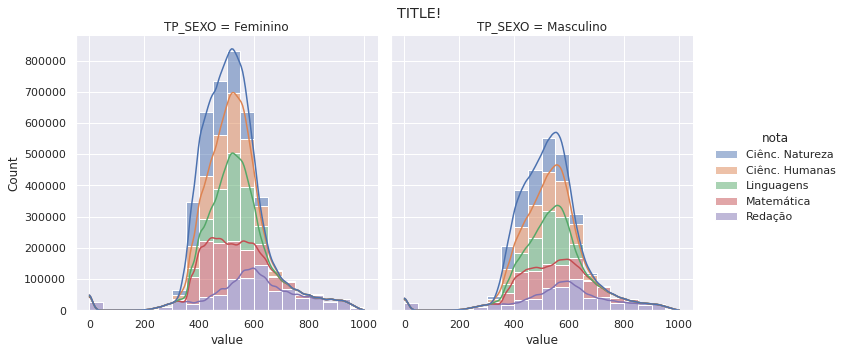

In [21]:
fig = plt.figure(figsize=(15,10))
sns.set_theme(style='darkgrid')

ax = sns.displot(
    dist_notas, 
    x='value', 
    hue='Nota', 
    col='Sexo', 
    multiple="stack", 
    kde=True,
    bins=20,)
ax.fig.subplots_adjust(top=0.9)
ax.fig.suptitle('Distribuição das notas por sexo - Enem 2019')
#fig.suptitle('Distribuição das notas por sexo - Enem 2019')
#ax.set_xlabel('Nota')
#ax.set_ylabel('Frequência')
#fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

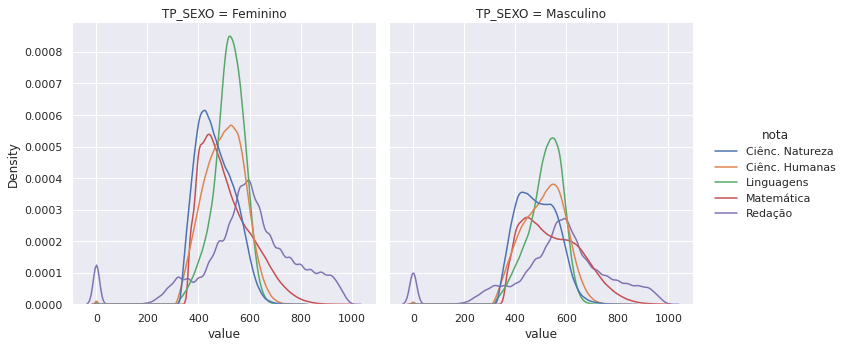

In [ ]:

sns.displot(dist_notas, x='value', hue='Nota', col='Sexo', kind='kde')
plt.title('Função densidade estimada das notas por sexo - Enem 2019')
plt.xlabel('Nota')
plt.ylabel('Densidade')
plt.show()

## Estatística Multivariada
- Notas x idade
- Notas x renda familiar
- Notas x internet na escola
- Notas x internet em casa
- Notas x profissão do pai
- Notas x profissão da mãe
- Notas x outras características da escola *

Tipos de análise:


y:..................x:....................stat:

numeric......numeric........pearson correlation

numeric......categorical....one-way ANOVA

categorical..numeric........Pearson chi-squared test

In [ ]:
enem19.head()

,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q012,Q019,Q022,Q024,Q025
8,2019,5,F,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,C,C,F,6,C,A,B,C,A,B,B,B,A,A
9,2019,2,M,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,543.9,548.1,502.5,480.7,1.0,120.0,40.0,120.0,120.0,0.0,400.0,E,E,B,B,5,F,A,B,C,B,B,B,C,B,B
11,2019,4,M,1,4,1,NaN,NaN,NaN,NaN,NaN,NaN,518.2,351.7,417.6,459.0,1.0,120.0,120.0,120.0,120.0,20.0,500.0,B,C,C,A,4,C,A,C,D,A,B,B,D,B,B
13,2019,6,F,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,458.9,441.6,413.0,399.0,1.0,80.0,40.0,40.0,80.0,0.0,240.0,E,E,E,B,4,D,A,B,C,A,B,B,C,A,A
15,2019,4,M,1,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,B,C,F,4,B,A,B,C,A,B,B,C,A,B


### Correlação entre variáveis categóricas

### Correlação entre variáveis numéricas

In [27]:
corr_df = pd.DataFrame(columns=['r', 'p_value'])
for col in enem19:
    if pd.api.types.is_numeric_dtype(enem19[col]):
        r, p = stats.spearmanr(enem19[col], enem19['NU_NOTA_MT'])
        corr_df.loc[col] = [round(r, 3), round(p, 3)]

/home/joao/anaconda3/envs/scraping/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [28]:
corr_df

,r,p_value
NU_ANO,NaN,NaN
TP_FAIXA_ETARIA,NaN,NaN
TP_ESTADO_CIVIL,NaN,NaN
TP_COR_RACA,NaN,NaN
TP_ESCOLA,NaN,NaN
TP_DEPENDENCIA_ADM_ESC,NaN,NaN
TP_LOCALIZACAO_ESC,NaN,NaN
TP_SIT_FUNC_ESC,NaN,NaN
NU_NOTA_CN,NaN,NaN
NU_NOTA_CH,NaN,NaN


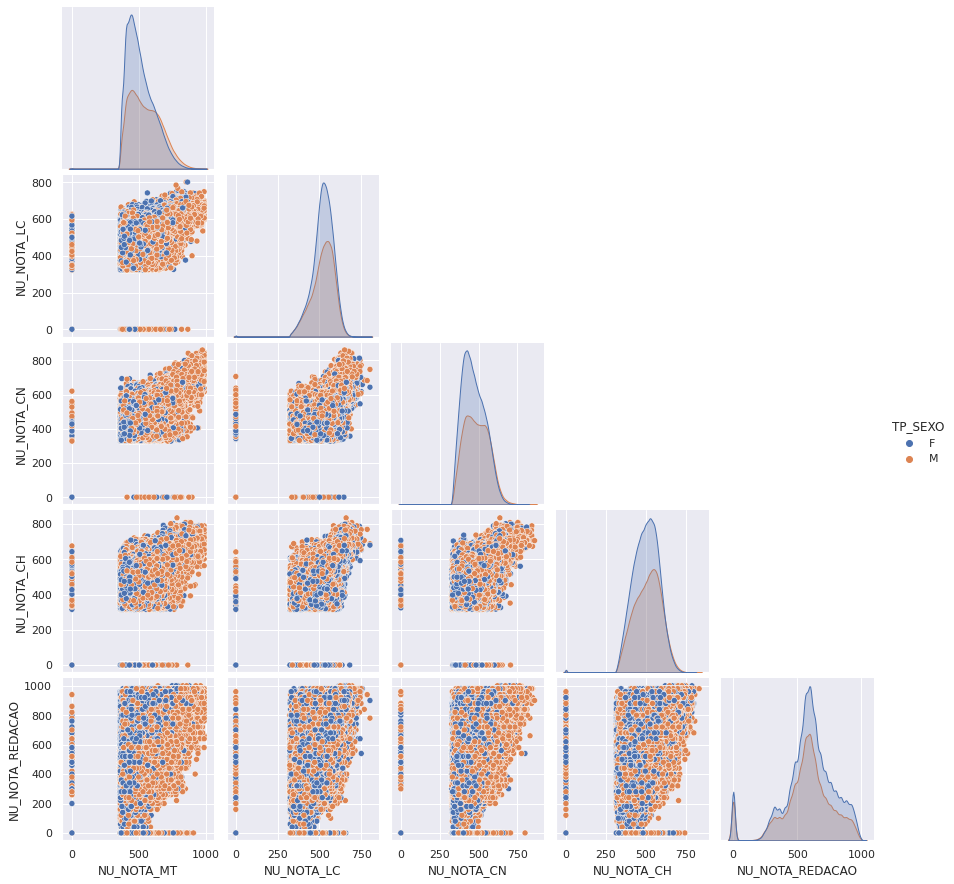

In [32]:
sns.pairplot(enem19, vars=['NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_REDACAO'], corner=True, hue='TP_SEXO');

# Análise Agregada